In [40]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.rc('font', family='Malgun Gothic')
plt.rc('axes', unicode_minus=False)

# General 만들때 쓴 타겟공식
- 이를 vip 에도 적용해서 분포확인

In [2]:
import pandas as pd
import numpy as np
import lightgbm as lgb
from scipy.stats import linregress
import os
import tqdm  # For progress bar if available, else standard print

# =============================================================================
# [설정] 컬럼명 및 파일 경로 설정
# =============================================================================
COL_ID = '발급회원번호'
COL_DATE = '기준년월'

# 분석 변수 (Wide Format의 접미사 '_MM' 등을 뗀 순수 컬럼명 가정)
COL_SPEND = '이용금액_신용_B0M'      # 소비
COL_COUNT = '이용건수_신용_B0M'      # 빈도
COL_COUNT_SPEND = '이용건수_신판_B0M' # 빈도 소비 (할부, 일시불)
COL_BALANCE = '잔액_B0M'             # 잔액
COL_CASH_ADV = '잔액_현금서비스_B0M' # 악성부채1
COL_CARD_LOAN = '잔액_카드론_B0M'    # 악성부채2
COL_DELINQ = '연체잔액_B0M'          # 리스크3
COL_AVG_BAL = '월중평잔'             # 자산

def calc_slope_long(series):
    """시계열 데이터(Series)의 선형 회귀 기울기를 계산"""
    y = series.values.astype(float)
    if len(y) < 2 or np.sum(y) == 0:
        return 0
    x = np.arange(len(y))
    slope, _, _, _, _ = linregress(x, y)
    return 0 if np.isnan(slope) else slope

# Additional columns for R12M fallback
COL_SPEND_R12M = '이용금액_신용_R12M'
COL_COUNT_R12M = '이용건수_신용_R12M'

def calculate_churn_scores(group):
    """고객 한 명의 데이터를 받아 점수 및 Target 생성 (1개월 이상 데이터 필요)"""
    # 데이터가 아예 없는 경우
    if len(group) < 1:
        return pd.Series({
            'Score_BadDebt': 0, 'Score_Delinq': 0, 'Score_Activity': 0, 'Score_Asset': 0,
            'Score_Status_Total': 0, 'Slope_Spend': 0, 'Slope_Balance': 0, 'Slope_Count': 0
        })

    # (A) 상태 점수 (Status Score) 세부 항목 계산
    try:
        # Helper for safe indexing
        def get_val(col, idx_from_last):
            # idx_from_last: 1 for last, 2 for 2nd last...
            if len(group) >= idx_from_last:
                return group[col].iloc[-idx_from_last]
            return 0

        # 1. [부정] 악성 부채 점수 (Score_BadDebt)
        # If only 1 month, cannot compare with previous, so score is 0
        val_last = get_val(COL_CASH_ADV, 1)
        val_prev = get_val(COL_CASH_ADV, 2)
        
        loan_last = get_val(COL_CARD_LOAN, 1)
        loan_prev = get_val(COL_CARD_LOAN, 2)
        
        bad_debt_score = (
            ((val_last - val_prev) / (val_prev + 1) * 1.5) +
            ((loan_last - loan_prev) / (loan_prev + 1) * 1.0)
        )
        
        # 2. [부정] 연체 강도 점수 (Score_Delinq)
        delinq_score = (get_val(COL_DELINQ, 1) * 3.0) + (get_val(COL_DELINQ, 2) * 2.0)
        if len(group) >= 3:
            delinq_score += (get_val(COL_DELINQ, 3) * 1.0)
        
        # 3. [긍정] 활동성 점수 (Score_Activity)
        sum_r3 = group[COL_COUNT_SPEND].iloc[-3:].sum()
        sum_r6 = group[COL_COUNT_SPEND].sum()
        activity_score = ((sum_r3 * 2) - sum_r6) / (sum_r6 + 1) * 100
        
        # 4. [긍정] 자산 방어 점수 (Score_Asset)
        avg_r3 = group[COL_AVG_BAL].iloc[-3:].mean()
        avg_r6 = group[COL_AVG_BAL].mean()
        asset_score = (avg_r3 / (avg_r6 + 1)) * 10
        
        # >> [Total] 상태 종합 점수 (Score_Status_Total)
        score_status_total = (bad_debt_score + delinq_score) - (activity_score + asset_score)
    except:
        bad_debt_score = 0
        delinq_score = 0
        activity_score = 0
        asset_score = 0
        score_status_total = 0

    # (B) 기울기 점수 (Slope Score)
    # CASE 1: Data >= 2 months (Use linregress)
    if len(group) >= 2:
        slope_spend = calc_slope_long(group[COL_SPEND])
        slope_balance = calc_slope_long(group[COL_BALANCE])
        slope_count = calc_slope_long(group[COL_COUNT])
    
    # CASE 2: Data == 1 month (Use R12M fallback)
    else:
        # Spending Slope Proxy: Current - Monthly_Avg(R12M)
        # If current < avg, result is negative (decrease) -> Condition met
        # If current > avg, result is positive (increase) -> Condition failed
        r12m_spend = group[COL_SPEND_R12M].iloc[0] if COL_SPEND_R12M in group.columns else 0
        avg_spend = r12m_spend / 12
        slope_spend = group[COL_SPEND].iloc[0] - avg_spend
        
        # Count Slope Proxy
        r12m_count = group[COL_COUNT_R12M].iloc[0] if COL_COUNT_R12M in group.columns else 0
        avg_count = r12m_count / 12
        slope_count = group[COL_COUNT].iloc[0] - avg_count
        
        # Balance Slope: User requested to exclude this (always satisfy).
        # We set it to -1 (or any value <= 0) to ensure the condition (slope <= 0) passes.
        slope_balance = -1

    return pd.Series({
        'Score_BadDebt': bad_debt_score,
        'Score_Delinq': delinq_score,
        'Score_Activity': activity_score,
        'Score_Asset': asset_score,
        'Score_Status_Total': score_status_total,
        'Slope_Spend': slope_spend,
        'Slope_Balance': slope_balance,
        'Slope_Count': slope_count
    })

def check_churn_condition(scores):
    """Calculates Target (1 or 0) from scores series"""
    # (조건 A) 기울기 3종(소비, 잔액, 건수)이 모두 0 이하
    cond_slopes_decrease = (
        (scores['Slope_Spend'] <= 0) & 
        (scores['Slope_Balance'] <= 0) & 
        (scores['Slope_Count'] <= 0)
    )
    
    # (조건 B) 4대 위험 징후 중 2개 이상 감지 (Risk_Count >= 2)
    cond1 = scores['Score_BadDebt'] > 0
    cond2 = scores['Score_Delinq'] > 0
    cond3 = scores['Score_Activity'] < 0
    cond4 = scores['Score_Asset'] == 0
    
    risk_count = int(cond1) + int(cond2) + int(cond3) + int(cond4)
    cond_high_risk = (risk_count >= 1)
    
    return 1 if (cond_slopes_decrease and cond_high_risk) else 0

def analyze_rolling_churn(file_path):
    print(f"\n[Info] 파일 로드 및 분석 시작: {file_path}")
    if not os.path.exists(file_path):
        print(f"❌ 파일을 찾을 수 없습니다: {file_path}")
        return

    # 1. Load Data
    try:
        df = pd.read_csv(file_path, low_memory=False)
        # Fill missing cols with 0 if needed
        # Added R12M columns to required list
        required_cols = [
            COL_ID, COL_DATE, COL_SPEND, COL_COUNT, COL_BALANCE, 
            COL_CASH_ADV, COL_CARD_LOAN, COL_DELINQ, COL_AVG_BAL,
            COL_SPEND_R12M, COL_COUNT_R12M
        ]
        for c in required_cols:
            if c not in df.columns: df[c] = 0
    except Exception as e:
        print(f"❌ 데이터 로드 실패: {e}")
        return

    # Sort
    df.sort_values(by=[COL_ID, COL_DATE], inplace=True)
    
    # Group by ID
    grouped = df.groupby(COL_ID)
    
    results = []
    
    print(" - 고객별 Rolling Analysis 진행 중... (데이터 최소 1개월 기준, 1개월 시 R12M 보완)")
    
    count_churners = 0
    total_processed = 0
    
    for cust_id, group in grouped:
        total_processed += 1
        # Minimum 1 months required logic now supported
        if len(group) < 1:
            continue
            
        # 1. "현재 시점"의 이탈 여부를 확인
        # (주의: 사용자가 원하는 것은 '현재 이탈자인 사람'의 과거 지속기간 확인이므로,
        # 가장 마지막 달이 Churn이어야 분석 대상이 됨)
        current_scores = calculate_churn_scores(group)
        is_current_churn = check_churn_condition(current_scores)
        
        if is_current_churn == 1:
            count_churners += 1
            
            # 2. 이탈자라면, 과거로 역추적 (Rolling)
            consecutive_months = 1 # Start with 1 (the current month)
            
            # Max lookback
            # If len=6, loops i=1 to 5 (check len=5 down to len=1)
            # If len=1, loop range(1, 1) -> Empty loop (correct, duration=1)
            max_lookback = len(group) - 1
            
            for i in range(1, max_lookback + 1):
                past_group = group.iloc[:-i] # Remove last i rows
                past_scores = calculate_churn_scores(past_group)
                is_past_churn = check_churn_condition(past_scores)
                
                if is_past_churn == 1:
                    consecutive_months += 1
                else:
                    break # Break chain
            
            results.append({
                'Cust_ID': cust_id,
                'Churn_Duration_Months': consecutive_months
            })
            
        # if total_processed % 1000 == 0:
        #     print(f"   ... {total_processed}명 처리 완료 (발견된 이탈자: {count_churners}명)")

    # Output Results
    if len(results) == 0:
        print("❌ 분석된 이탈자가 없습니다.")
        return

    df_res = pd.DataFrame(results)
    
    print("\n" + "="*50)
    print(f"📊 이탈자 Rolling 분석 결과 (대상 파일: {os.path.basename(file_path)})")
    print("="*50)
    print(f" - 총 분석 고객 수: {total_processed}명")
    print(f" - 최종 시점 이탈자 수: {len(df_res)}명 ({len(df_res)/total_processed*100:.2f}%)")
    print("-" * 30)
    print(" [이탈 징후 지속 기간 통계]")
    print(df_res['Churn_Duration_Months'].describe())
    print("-" * 30)
    print(" [기간별 분포 (상위 10개)]")
    print(df_res['Churn_Duration_Months'].value_counts().sort_index(ascending=False).head(10))
    
    # Save detailed results
    save_path = f"churn_duration_results_{os.path.basename(file_path)}"
    # df_res.to_csv(save_path, index=False)
    print(f"\n✅ 상세 결과 저장 완료: {save_path}")

    return df_res,df

## VIP 로드

In [4]:
TEST_FILE = '../260108/VIP/combined_part1.csv'
df_res, df = analyze_rolling_churn(TEST_FILE)


[Info] 파일 로드 및 분석 시작: ../260108/VIP/combined_part1.csv
 - 고객별 Rolling Analysis 진행 중... (데이터 최소 1개월 기준, 1개월 시 R12M 보완)


C:\Users\johnh\AppData\Local\Temp\ipykernel_6748\2882551176.py:76: RuntimeWarning: divide by zero encountered in scalar divide
  activity_score = ((sum_r3 * 2) - sum_r6) / (sum_r6 + 1) * 100



📊 이탈자 Rolling 분석 결과 (대상 파일: combined_part1.csv)
 - 총 분석 고객 수: 100000명
 - 최종 시점 이탈자 수: 31456명 (31.46%)
------------------------------
 [이탈 징후 지속 기간 통계]
count    31456.000000
mean         1.377893
std          0.937076
min          1.000000
25%          1.000000
50%          1.000000
75%          1.000000
max          6.000000
Name: Churn_Duration_Months, dtype: float64
------------------------------
 [기간별 분포 (상위 10개)]
Churn_Duration_Months
6      705
5      126
4      370
3     1197
2     4354
1    24704
Name: count, dtype: int64

✅ 상세 결과 저장 완료: churn_duration_results_combined_part1.csv


### 타겟 관련 함수

In [6]:
import pandas as pd
import numpy as np
import os
from scipy.stats import linregress

# [설정] 컬럼명 상수는 기존과 동일하다고 가정
# COL_ID, COL_DATE, COL_SPEND 등...

def analyze_and_extract_features_v2(input_data):
    """
    input_data: 
      - 파일 경로 (str) -> 파일을 로드하여 분석
      - 데이터프레임 (pd.DataFrame) -> 기존 로드된 데이터로 분석
    """
    
    # 1. 데이터 로드 단계 (분기 처리)
    if isinstance(input_data, pd.DataFrame):
        print(f"\n[Info] 기존 DataFrame을 활용하여 분석을 시작합니다. (Rows: {len(input_data)})")
        df = input_data.copy() # 원본 오염 방지를 위해 복사본 사용 권장
    elif isinstance(input_data, str):
        print(f"\n[Info] 파일 로드 및 분석 시작: {input_data}")
        if not os.path.exists(input_data):
            print(f"❌ 파일을 찾을 수 없습니다: {input_data}")
            return None, None
        try:
            df = pd.read_csv(input_data, low_memory=False)
        except Exception as e:
            print(f"❌ 데이터 로드 실패: {e}")
            return None, None
    else:
        print("❌ 잘못된 입력입니다. 파일 경로(str) 또는 DataFrame 객체를 넣어주세요.")
        return None, None

    # 2. 필수 컬럼 확인 및 결측치 처리 (안전장치)
    required_cols = [
        COL_ID, COL_DATE, COL_SPEND, COL_COUNT, COL_BALANCE, 
        COL_CASH_ADV, COL_CARD_LOAN, COL_DELINQ, COL_AVG_BAL,
        COL_SPEND_R12M, COL_COUNT_R12M, COL_COUNT_SPEND
    ]
    
    # 없는 컬럼 0으로 채우기
    for c in required_cols:
        if c not in df.columns:
            # print(f"⚠️ 경고: '{c}' 컬럼이 없어 0으로 채웁니다.") # 너무 시끄러우면 주석 처리
            df[c] = 0

    # 3. 정렬 및 그룹핑
    # 이미 정렬되어 있을 수 있지만, 안전을 위해 다시 정렬
    df.sort_values(by=[COL_ID, COL_DATE], inplace=True)
    grouped = df.groupby(COL_ID)
    
    # 4. 분석 진행 (기존 로직 동일)
    churn_results = []   
    feature_list = []    

    print(" - 고객별 파생변수 생성 및 이탈 분석 중...")
    
    # (진행상황 표시용 카운터)
    total_processed = 0
    
    for cust_id, group in grouped:
        total_processed += 1
        if len(group) < 1: continue
            
        # (A) 현재 시점 점수 및 기울기 계산 (시각화용 데이터 수집)
        current_scores = calculate_churn_scores(group) 
        
        feature_data = current_scores.to_dict()
        feature_data[COL_ID] = cust_id
        feature_list.append(feature_data)

        # (B) 이탈 여부 판단 및 기간 추적 (이탈자 리스트용)
        is_current_churn = check_churn_condition(current_scores)
        
        if is_current_churn == 1:
            consecutive_months = 1
            max_lookback = len(group) - 1
            for i in range(1, max_lookback + 1):
                past_group = group.iloc[:-i]
                past_scores = calculate_churn_scores(past_group)
                if check_churn_condition(past_scores) == 1:
                    consecutive_months += 1
                else:
                    break
            
            churn_results.append({
                'Cust_ID': cust_id,
                'Churn_Duration_Months': consecutive_months
            })

    # 5. 결과 반환
    df_churn_res = pd.DataFrame(churn_results)
    df_features = pd.DataFrame(feature_list)

    print("\n" + "="*50)
    print(f"📊 분석 완료")
    print(f" - 총 분석 고객: {len(df_features)}명")
    print(f" - 이탈 감지 고객: {len(df_churn_res)}명")
    print("="*50)
    
    return df_churn_res, df_features

In [7]:
df_res,df_viz = analyze_and_extract_features_v2(df)


[Info] 기존 DataFrame을 활용하여 분석을 시작합니다. (Rows: 600000)
 - 고객별 파생변수 생성 및 이탈 분석 중...


C:\Users\johnh\AppData\Local\Temp\ipykernel_6748\2882551176.py:76: RuntimeWarning: divide by zero encountered in scalar divide
  activity_score = ((sum_r3 * 2) - sum_r6) / (sum_r6 + 1) * 100



📊 분석 완료
 - 총 분석 고객: 100000명
 - 이탈 감지 고객: 31456명


## vip 기울기 점수 및 상태기반 점수 시각화

c:\Users\johnh\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\core\_methods.py:49: RuntimeWarning: invalid value encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)


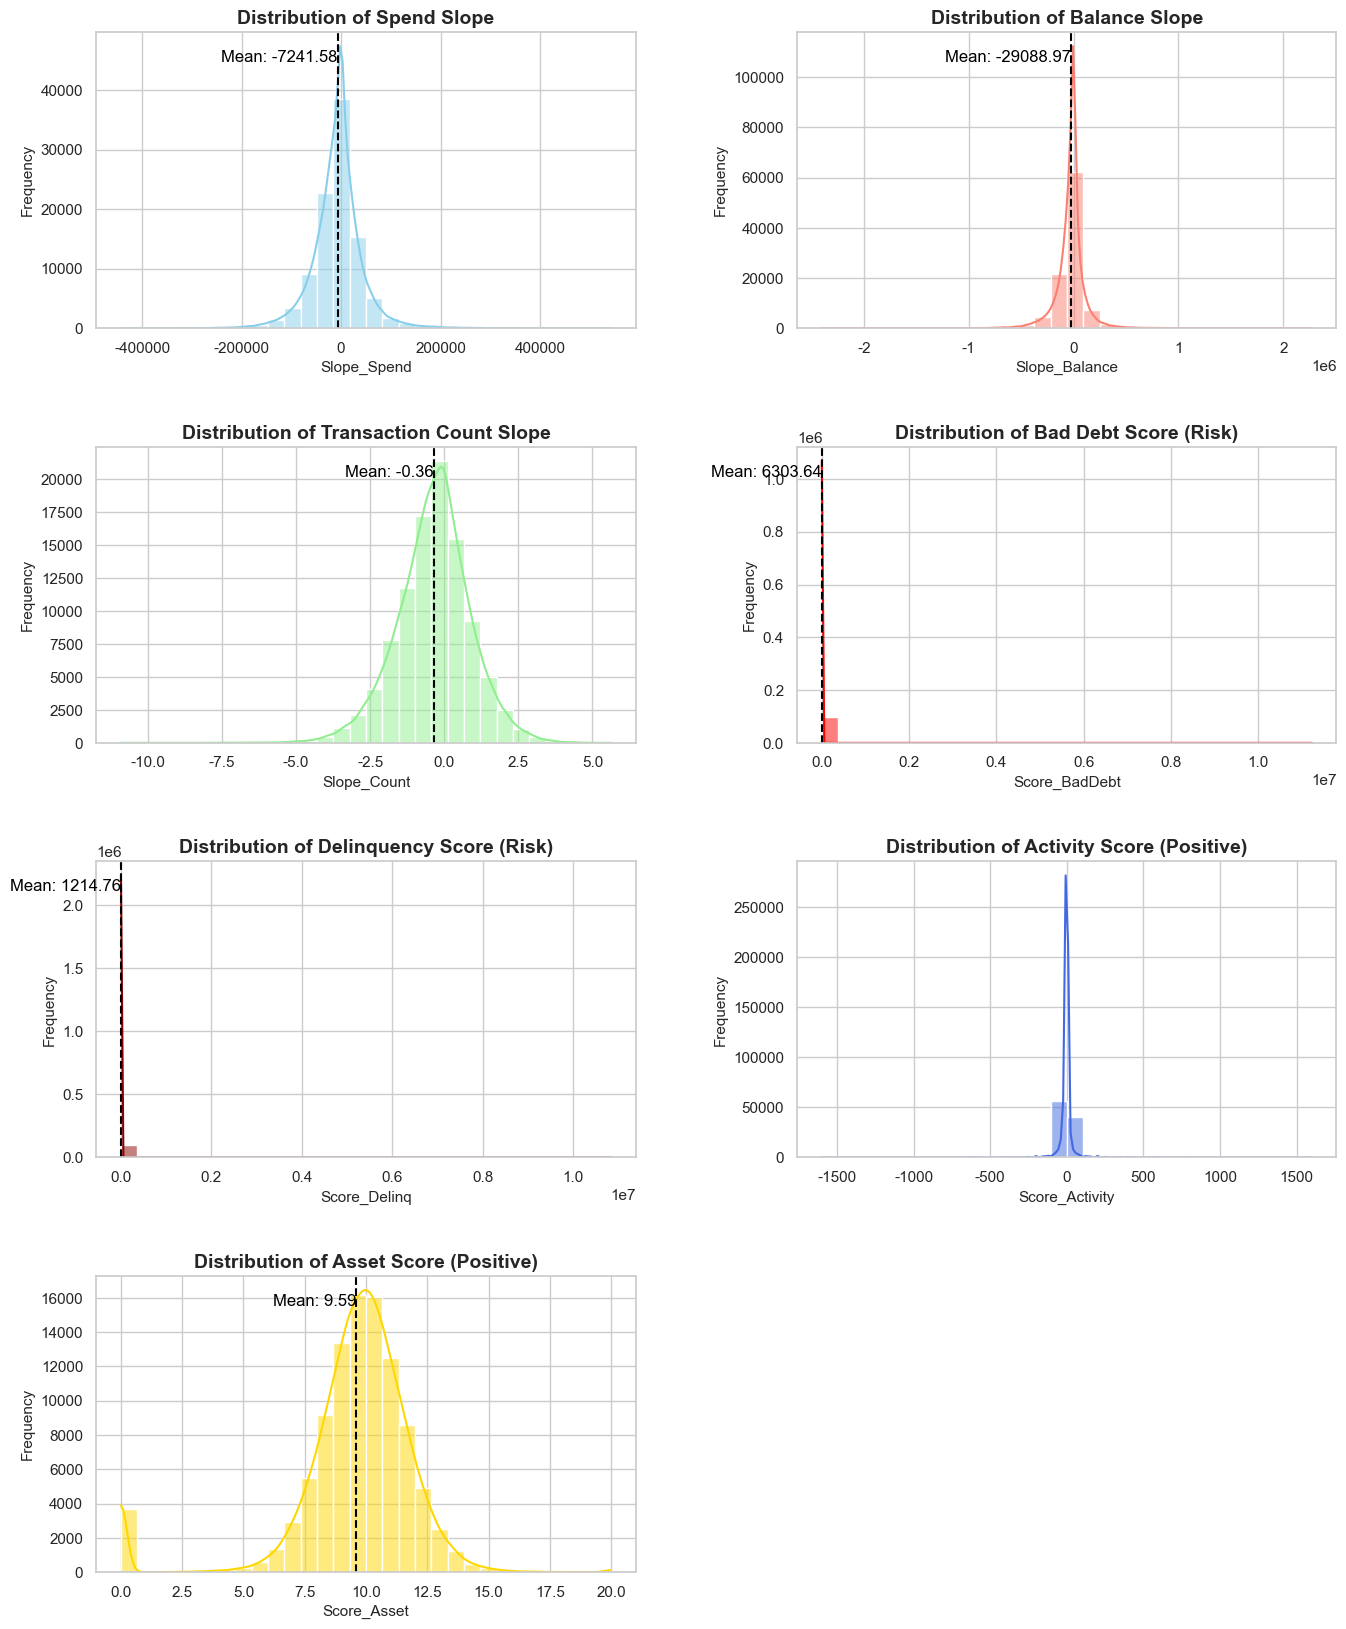

📊 7대 주요 지표 분포 시각화 완료


In [8]:

# =============================================================================
# [시각화] 주요 변수 7종 분포 확인 (Visualization)
# =============================================================================

# 1. 그래프 스타일 및 캔버스 설정
sns.set(style="whitegrid")

# 4행 2열의 서브플롯 생성 (총 8개 공간, 7개 변수 사용)
fig, axes = plt.subplots(4, 2, figsize=(16, 20))
plt.subplots_adjust(hspace=0.4, wspace=0.3) # 그래프 간 간격 조정

# 변수 목록 및 제목 매핑
vars_to_plot = [
    ('Slope_Spend', 'Distribution of Spend Slope', 'skyblue'),
    ('Slope_Balance', 'Distribution of Balance Slope', 'salmon'),
    ('Slope_Count', 'Distribution of Transaction Count Slope', 'lightgreen'),
    ('Score_BadDebt', 'Distribution of Bad Debt Score (Risk)', 'red'),
    ('Score_Delinq', 'Distribution of Delinquency Score (Risk)', 'darkred'),
    ('Score_Activity', 'Distribution of Activity Score (Positive)', 'royalblue'),
    ('Score_Asset', 'Distribution of Asset Score (Positive)', 'gold')
]

# 2. 반복문을 통해 그래프 생성
flat_axes = axes.flatten() # 2차원 배열을 1차원으로 펼침

for i, (col, title, color) in enumerate(vars_to_plot):
    ax = flat_axes[i]
    
    # 히스토그램 & KDE(밀도) 그래프 그리기
    sns.histplot(data=df_viz, x=col, kde=True, ax=ax, color=color, bins=30)
    
    # 그래프 꾸미기
    ax.set_title(title, fontsize=14, fontweight='bold')
    ax.set_xlabel(col, fontsize=11)
    ax.set_ylabel('Frequency', fontsize=11)
    
    # 평균선 추가 (점선)
    mean_val = df_viz[col].mean()
    ax.axvline(mean_val, color='black', linestyle='--', linewidth=1.5)
    ax.text(mean_val, ax.get_ylim()[1]*0.9, f'Mean: {mean_val:.2f}', color='black', ha='right')

# 3. 남는 칸(8번째) 숨기기 및 레이아웃 정리
if len(vars_to_plot) < len(flat_axes):
    for j in range(len(vars_to_plot), len(flat_axes)):
        fig.delaxes(flat_axes[j])

# 그래프 출력
plt.show()

print("📊 7대 주요 지표 분포 시각화 완료")

## 모델용 데이터 생성

In [34]:
import pandas as pd
import numpy as np

def make_ml_dataset_final(df_raw, df_scores_viz=None):
    """
    df_raw: 원본 시계열 데이터 (df) - Feature 추출용
    df_scores_viz: 이미 계산된 점수 데이터 (df_viz) - Target 생성용 (없으면 다시 계산)
    """
    print(f"[Info] 모델 학습용 최종 데이터셋 생성 시작")

    # =========================================================
    # 1. Target 생성 (보내주신 로직 100% 반영)
    # =========================================================
    
    # 만약 df_viz(이미 계산된 점수표)가 있다면 재활용 (속도 향상)
    if df_scores_viz is not None:
        print(" - 기존에 계산된 Score 데이터(df_viz)를 활용합니다.")
        df_target = df_scores_viz.copy()
    else:
        # 없으면 df_raw를 이용해 새로 계산
        print(" - Score 데이터를 새로 계산합니다...")
        # (기존 calculate_churn_scores 함수 활용)
        df_target = df_raw.groupby(COL_ID).apply(calculate_churn_scores).reset_index()

    print(" - 이탈(Target) 라벨링 진행 중...")
    
    # [Target Logic]
    # (조건 A) 기울기 3종(소비, 잔액, 건수)이 모두 0 이하
    cond_slopes_decrease = (
        (df_target['Slope_Spend'] <= 0) & 
        (df_target['Slope_Balance'] <= 0) & 
        (df_target['Slope_Count'] <= 0)
    )
    
    # (조건 B) 4대 위험 징후 중 1개 이상 감지
    # (코드 안정성을 위해 컬럼 존재 여부 확인 후 처리)
    c1 = df_target['Score_BadDebt'] > 0 if 'Score_BadDebt' in df_target else False
    c2 = df_target['Score_Delinq'] > 0 if 'Score_Delinq' in df_target else False
    c3 = df_target['Score_Activity'] < 0 if 'Score_Activity' in df_target else False
    c4 = df_target['Score_Asset'] == 0 if 'Score_Asset' in df_target else False
    
    risk_count = c1.astype(int) + c2.astype(int) + c3.astype(int) + c4.astype(int)
    cond_high_risk = (risk_count >= 1)
    
    # 최종 Target 할당
    df_target['Target'] = np.where(cond_slopes_decrease & cond_high_risk, 1, 0)

    # =========================================================
    # 2. Raw Features (학습용 원본 데이터) 추출
    # =========================================================
    print(" - 고객별 최신 원본 데이터 추출 중...")
    
    # 모델은 '점수'가 아니라 '실제 금액/건수'를 보고 학습해야 하므로,
    # 각 고객의 가장 최근(마지막) 달 데이터를 가져옵니다.
    df_features = df_raw.sort_values(by=[COL_ID, COL_DATE]).groupby(COL_ID).last().reset_index()

    # =========================================================
    # 3. 데이터 병합 (Merge)
    # =========================================================
    print(" - Target 정보와 Feature 정보 병합 중...")
    
    # df_target에는 [Cust_ID, Target, Scores...]가 있고
    # df_features에는 [Cust_ID, 이용금액, 잔액, 연체...]가 있습니다.
    
    # '발급회원번호'(COL_ID) 기준으로 병합
    # df_target의 인덱스가 ID인 경우를 대비해 컬럼으로 변환
    if COL_ID not in df_target.columns and df_target.index.name == COL_ID:
        df_target = df_target.reset_index()
        
    df_final = pd.merge(df_features, df_target[[COL_ID, 'Target']], on=COL_ID, how='inner')
    
    print("\n" + "="*40)
    print(f"✅ 최종 데이터셋 생성 완료")
    print(f" - 총 데이터 수: {len(df_final)}명")
    print(f" - Target 분포:\n{df_final['Target'].value_counts()}")
    print("="*40)
    
    return df_final

# =========================================================
# [실행 방법]
# 1. df (원본)와 df_viz (점수)가 모두 있는 경우 (권장)
# df_train = make_ml_dataset_final(df, df_viz)

# 2. df만 있는 경우
# df_train = make_ml_dataset_final(df)
# =========================================================

In [35]:
# [실행] 기존에 로드해둔 df를 넣으세요
df_ml = make_ml_dataset_final(df, df_viz)

[Info] 모델 학습용 최종 데이터셋 생성 시작
 - 기존에 계산된 Score 데이터(df_viz)를 활용합니다.
 - 이탈(Target) 라벨링 진행 중...
 - 고객별 최신 원본 데이터 추출 중...
 - Target 정보와 Feature 정보 병합 중...

✅ 최종 데이터셋 생성 완료
 - 총 데이터 수: 100000명
 - Target 분포:
Target
0    68544
1    31456
Name: count, dtype: int64


In [ ]:
df_ml.info()

### 모델 학습 - RandomForest

In [55]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def run_rf_simulation(data, drop_cols=[]):
    print(f"[Info] Random Forest 모델 학습 시작")
    
    # 1. 전처리
    data_clean = data.replace([np.inf, -np.inf], np.nan).fillna(0)
    targets_to_drop = ['Cust_ID', 'Target'] + drop_cols
    X_temp = data_clean.drop(columns=targets_to_drop, errors='ignore')
    y = data_clean['Target']
    
    X = X_temp.select_dtypes(include=['number'])
    
    # 2. Split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )
    
    # 3. 학습
    rf = RandomForestClassifier(
        n_estimators=200, max_depth=10, min_samples_leaf=4,
        random_state=42, class_weight='balanced', n_jobs=-1
    )
    rf.fit(X_train, y_train)
    
    # 4. 예측
    y_pred = rf.predict(X_test)
    y_prob = rf.predict_proba(X_test)[:, 1] # 확률
    
    # 5. 점수 계산
    acc = accuracy_score(y_test, y_pred)
    roc = roc_auc_score(y_test, y_prob)
    
    print("\n" + "="*50)
    print("📊 Random Forest 최종 평가")
    print("="*50)
    print(f"★ ROC-AUC Score: {roc:.4f}")
    print(f"정확도(Accuracy): {acc:.4f}")
    print("-" * 50)
    print(classification_report(y_test, y_pred))
    
    # 6. [복구됨] 혼동행렬 시각화
    plt.figure(figsize=(5, 4))
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix (RF)\nROC-AUC: {roc:.4f}')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()
    
    return rf

[Info] Random Forest 모델 학습 시작

📊 Random Forest 최종 평가
★ ROC-AUC Score: 0.7381
정확도(Accuracy): 0.6821
--------------------------------------------------
              precision    recall  f1-score   support

           0       0.81      0.69      0.75     13709
           1       0.50      0.66      0.56      6291

    accuracy                           0.68     20000
   macro avg       0.66      0.67      0.66     20000
weighted avg       0.71      0.68      0.69     20000



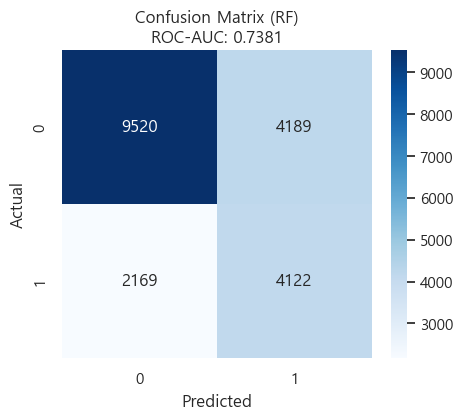

In [56]:
# 데이터 누수 리스트 정의
leakage_cols = [
        'Target', '발급회원번호', 'Unnamed: 0', '기준년월',
        'Slope_Spend', 'Slope_Balance', 'Slope_Count', 
        'Norm_Slope_Spend', 'Norm_Slope_Balance', 'Norm_Slope_Count',
        'Score_BadDebt', 'Score_Delinq', 'Score_Activity', 'Score_Asset',
        'Score_Status_Total', 'Score_Slope_Total', 'Final_Total_Score',
        'Risk_Count', 'Churn_Segment',
        'Cond1_Has_BadDebt', 'Cond2_Has_Delinq', 'Cond3_Activity_Drop', 'Cond4_Asset_Zero',
        '이용건수_신용_R6M', '이용건수_신용_R3M', '이용건수_일시불_R6M', '이용건수_신판_R3M', '이용건수_신판_R6M', '이용건수_신용_B0M',
        '이용건수_일시불_R3M','최종이용일자_기본', '이용건수_신판_B0M','최종이용일자_신판', '이용건수_일시불_B0M',
        '최종이용일자_일시불', '이용후경과월_일시불', '_1순위카드이용건수'
    ]

# [실행]
if df_ml is not None:
    model = run_rf_simulation(df_ml, drop_cols=leakage_cols)

### XGBoost

In [57]:
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
import re

def run_xgboost_simulation(data, drop_cols=[]):
    print(f"[Info] XGBoost 모델 학습 시작")
    
    # 1. 전처리
    data_clean = data.replace([np.inf, -np.inf], np.nan).fillna(0)
    targets_to_drop = ['Cust_ID', 'Target'] + drop_cols
    X_temp = data_clean.drop(columns=targets_to_drop, errors='ignore')
    y = data_clean['Target']
    X = X_temp.select_dtypes(include=['number'])
    
    # 컬럼명 세탁
    regex = re.compile(r"\[|\]|<", re.IGNORECASE)
    X.columns = ["".join(x.split()) for x in X.columns]
    X.columns = [regex.sub("_", col) if any(x in str(col) for x in set(('[', ']', '<'))) else col for col in X.columns]

    # 2. Split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )
    
    # 가중치
    count_neg = (y_train == 0).sum()
    count_pos = (y_train == 1).sum()
    scale_weight = count_neg / count_pos if count_pos > 0 else 1

    # 3. 학습
    xgb_model = xgb.XGBClassifier(
        n_estimators=200, learning_rate=0.05, max_depth=8,
        scale_pos_weight=scale_weight, random_state=42, n_jobs=-1, tree_method='hist'
    )
    xgb_model.fit(X_train, y_train)
    
    # 4. 예측
    y_pred = xgb_model.predict(X_test)
    y_prob = xgb_model.predict_proba(X_test)[:, 1]
    
    # 5. 점수
    acc = accuracy_score(y_test, y_pred)
    roc = roc_auc_score(y_test, y_prob)
    
    print("\n" + "="*50)
    print("📊 XGBoost 최종 평가")
    print("="*50)
    print(f"★ ROC-AUC Score: {roc:.4f}")
    print(f"정확도(Accuracy): {acc:.4f}")
    print("-" * 50)
    print(classification_report(y_test, y_pred))
    
    # 6. [복구됨] 혼동행렬 시각화
    plt.figure(figsize=(5, 4))
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Oranges')
    plt.title(f'Confusion Matrix (XGB)\nROC-AUC: {roc:.4f}')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()
    
    return xgb_model

[Info] XGBoost 모델 학습 시작

📊 XGBoost 최종 평가
★ ROC-AUC Score: 0.8679
정확도(Accuracy): 0.7872
--------------------------------------------------
              precision    recall  f1-score   support

           0       0.88      0.80      0.84     13709
           1       0.64      0.76      0.69      6291

    accuracy                           0.79     20000
   macro avg       0.76      0.78      0.76     20000
weighted avg       0.80      0.79      0.79     20000



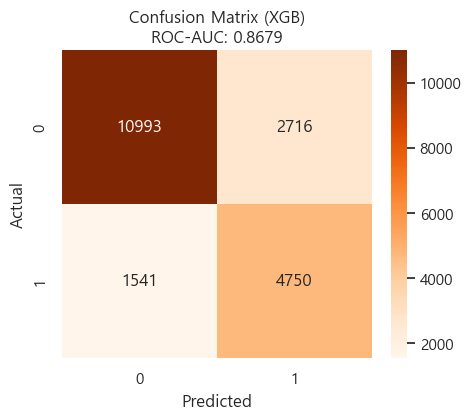

In [58]:
# =========================================================
# [실행]
# df_train(또는 df_ml)은 아까 만드신 최종 데이터셋입니다.
# leakage_cols는 아까 정의하신 리스트 그대로 쓰시면 됩니다.
# =========================================================
# 데이터 누수 리스트 정의
leakage_cols = [
        'Target', '발급회원번호', 'Unnamed: 0', '기준년월',
        'Slope_Spend', 'Slope_Balance', 'Slope_Count', 
        'Norm_Slope_Spend', 'Norm_Slope_Balance', 'Norm_Slope_Count',
        'Score_BadDebt', 'Score_Delinq', 'Score_Activity', 'Score_Asset',
        'Score_Status_Total', 'Score_Slope_Total', 'Final_Total_Score',
        'Risk_Count', 'Churn_Segment',
        'Cond1_Has_BadDebt', 'Cond2_Has_Delinq', 'Cond3_Activity_Drop', 'Cond4_Asset_Zero',
        '이용건수_신용_R6M', '이용건수_신용_R3M', '이용건수_일시불_R6M', '이용건수_신판_R3M', '이용건수_신판_R6M', '이용건수_신용_B0M',
        '이용건수_일시불_R3M','최종이용일자_기본', '이용건수_신판_B0M','최종이용일자_신판', '이용건수_일시불_B0M',
        '최종이용일자_일시불', '이용후경과월_일시불', '_1순위카드이용건수'
    ]



xgb_final = run_xgboost_simulation(df_ml, drop_cols=leakage_cols)

### LightGBM

In [59]:
import lightgbm as lgb
import matplotlib.pyplot as plt
import seaborn as sns
import re

def run_lightgbm_simulation(data, drop_cols=[]):
    print(f"[Info] LightGBM 모델 학습 시작")
    
    # 1. 전처리
    data_clean = data.replace([np.inf, -np.inf], np.nan).fillna(0)
    targets_to_drop = ['Cust_ID', 'Target'] + drop_cols
    X_temp = data_clean.drop(columns=targets_to_drop, errors='ignore')
    y = data_clean['Target']
    X = X_temp.select_dtypes(include=['number'])
    
    # 컬럼명 세탁
    regex = re.compile(r"[\[\]<>\s,]", re.IGNORECASE)
    X.columns = [regex.sub("_", str(col)) for col in X.columns]

    # 2. Split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )
    
    # 가중치
    count_neg = (y_train == 0).sum()
    count_pos = (y_train == 1).sum()
    scale_weight = count_neg / count_pos if count_pos > 0 else 1

    # 3. 학습
    lgbm_model = lgb.LGBMClassifier(
        n_estimators=200, learning_rate=0.05, max_depth=8, num_leaves=31,
        scale_pos_weight=scale_weight, random_state=42, n_jobs=-1, verbose=-1
    )
    lgbm_model.fit(X_train, y_train)
    
    # 4. 예측
    y_pred = lgbm_model.predict(X_test)
    y_prob = lgbm_model.predict_proba(X_test)[:, 1]
    
    # 5. 점수
    acc = accuracy_score(y_test, y_pred)
    roc = roc_auc_score(y_test, y_prob)
    
    print("\n" + "="*50)
    print("📊 LightGBM 최종 평가")
    print("="*50)
    print(f"★ ROC-AUC Score: {roc:.4f}")
    print(f"정확도(Accuracy): {acc:.4f}")
    print("-" * 50)
    print(classification_report(y_test, y_pred))
    
    # 6. [복구됨] 혼동행렬 시각화
    plt.figure(figsize=(5, 4))
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Greens')
    plt.title(f'Confusion Matrix (LGBM)\nROC-AUC: {roc:.4f}')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()
    
    return lgbm_model

[Info] LightGBM 모델 학습 시작

📊 LightGBM 최종 평가
★ ROC-AUC Score: 0.8599
정확도(Accuracy): 0.7725
--------------------------------------------------
              precision    recall  f1-score   support

           0       0.89      0.77      0.82     13709
           1       0.61      0.79      0.69      6291

    accuracy                           0.77     20000
   macro avg       0.75      0.78      0.75     20000
weighted avg       0.80      0.77      0.78     20000



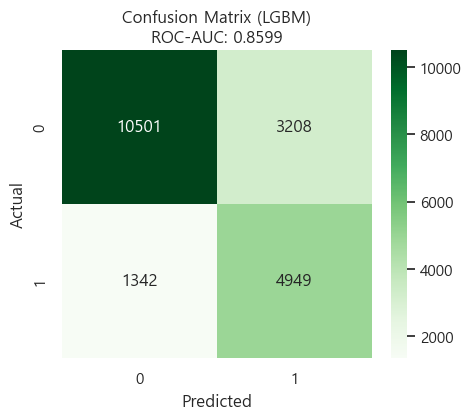

In [67]:
# =========================================================
# [실행]
# df_train(또는 df_ml)은 최종 데이터셋입니다.
# leakage_cols는 아까 정의하신 리스트입니다.
# =========================================================

lgbm_final = run_lightgbm_simulation(df_ml, drop_cols=leakage_cols)

# 모델들의 성능 비교 시각화

## x_test , y_test 반환

In [68]:
from sklearn.model_selection import train_test_split
import re

# 1. 아까 사용했던 데이터셋 (df_final 또는 df_ml)
# 변수명이 df_final 이라고 가정하겠습니다. (없으면 df_ml 등 사용하신 걸로 바꾸세요)
target_df = df_ml 

# 2. 학습 때 뺐던 컬럼들 (Leakage 등)
# 아까 정의하신 리스트 그대로 가져옵니다.
drop_cols = [
        'Target', '발급회원번호', 'Unnamed: 0', '기준년월',
        'Slope_Spend', 'Slope_Balance', 'Slope_Count', 
        'Norm_Slope_Spend', 'Norm_Slope_Balance', 'Norm_Slope_Count',
        'Score_BadDebt', 'Score_Delinq', 'Score_Activity', 'Score_Asset',
        'Score_Status_Total', 'Score_Slope_Total', 'Final_Total_Score',
        'Risk_Count', 'Churn_Segment',
        'Cond1_Has_BadDebt', 'Cond2_Has_Delinq', 'Cond3_Activity_Drop', 'Cond4_Asset_Zero',
        '이용건수_신용_R6M', '이용건수_신용_R3M', '이용건수_일시불_R6M', '이용건수_신판_R3M', '이용건수_신판_R6M', '이용건수_신용_B0M',
        '이용건수_일시불_R3M','최종이용일자_기본', '이용건수_신판_B0M','최종이용일자_신판', '이용건수_일시불_B0M',
        '최종이용일자_일시불', '이용후경과월_일시불', '_1순위카드이용건수'
    ]

# 3. 데이터 분리 및 전처리 (학습 때와 동일하게!)
X_temp = target_df.drop(columns=drop_cols, errors='ignore')
y = target_df['Target']

# 숫자형만 선택 & 컬럼명 특수문자 제거 (LGBM/XGB 에러 방지용 필수 전처리)
X = X_temp.select_dtypes(include=['number'])
regex = re.compile(r"[\[\]<>\s,]", re.IGNORECASE)
X.columns = [regex.sub("_", str(col)) for col in X.columns]

# 4. Train/Test 나누기 (random_state=42로 고정했으므로 아까와 똑같이 나뉩니다)
_, X_test, _, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"✅ 테스트 데이터 준비 완료 (X_test: {X_test.shape})")

✅ 테스트 데이터 준비 완료 (X_test: (20000, 845))


## 시각화

In [69]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, confusion_matrix

def compare_existing_models(models_dict, X_test, y_test):
    print(f"[Info] 저장된 모델들을 불러와 비교 분석합니다...")
    
    # 결과 담을 표
    metrics_list = []
    
    # 캔버스 설정
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    ax_roc = axes[0, 0]
    ax_bar = axes[0, 1]
    
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c'] # 파랑, 주황, 초록
    
    for i, (name, model) in enumerate(models_dict.items()):
        if model is None:
            print(f"⚠️ {name} 모델 변수가 없습니다. 건너뜁니다.")
            continue
            
        # 예측
        y_pred = model.predict(X_test)
        y_prob = model.predict_proba(X_test)[:, 1]
        
        # 점수 계산
        acc = accuracy_score(y_test, y_pred)
        rec = recall_score(y_test, y_pred)
        prec = precision_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        auc = roc_auc_score(y_test, y_prob)
        
        metrics_list.append({
            'Model': name, 'Accuracy': acc, 'Recall': rec, 
            'Precision': prec, 'F1-Score': f1, 'ROC-AUC': auc
        })
        
        # 1. ROC Curve 그리기
        fpr, tpr, _ = roc_curve(y_test, y_prob)
        ax_roc.plot(fpr, tpr, label=f"{name} (AUC={auc:.4f})", color=colors[i], linewidth=2)
        
        # 2. Confusion Matrix (하단에 작게 그리기 위해 별도 처리 안함, 아래서 따로 그림)

    # ROC 그래프 꾸미기
    ax_roc.plot([0, 1], [0, 1], 'k--', alpha=0.5)
    ax_roc.set_title('ROC Curve Comparison')
    ax_roc.set_xlabel('False Positive Rate')
    ax_roc.set_ylabel('True Positive Rate (Recall)')
    ax_roc.legend()
    ax_roc.grid(True)
    
    # 3. 성능 비교 Bar Chart (Recall & Accuracy)
    metrics_df = pd.DataFrame(metrics_list).set_index('Model')
    metrics_df[['Recall', 'ROC-AUC']].plot(kind='bar', ax=ax_bar, color=['salmon', 'skyblue'])
    ax_bar.set_title('Key Metrics Comparison (Recall vs ROC-AUC)')
    ax_bar.set_ylim(0, 1.05)
    for p in ax_bar.patches:
        ax_bar.annotate(f"{p.get_height():.2f}", (p.get_x() + p.get_width() / 2., p.get_height()), 
                        ha='center', va='bottom', fontsize=10)

    # 4. 혼동 행렬 (하단 2개)
    # 공간상 상위 2개 모델(혹은 전체)만 표시
    for i, (name, model) in enumerate(models_dict.items()):
        if i >= 2: break # 공간 부족으로 2개만 (필요시 조정)
        
        y_pred = model.predict(X_test)
        cm = confusion_matrix(y_test, y_pred)
        
        sns.heatmap(cm, annot=True, fmt='d', cmap=plt.cm.Blues if i==0 else plt.cm.Oranges, ax=axes[1, i])
        axes[1, i].set_title(f'{name} Confusion Matrix')
        axes[1, i].set_ylabel('Actual')
        axes[1, i].set_xlabel('Predicted')

    # 남은 칸(axes[1, 1] 등) 처리
    if len(models_dict) < 3:
        fig.delaxes(axes[1, 1]) # 모델 적으면 빈칸 삭제
    elif len(models_dict) >= 3:
         # 3번째 모델 혼동행렬 (자리가 없어서 덮어쓰거나 별도 처리 필요하지만, 여기선 2개까지만 보여줌)
         pass 

    plt.tight_layout()
    plt.show()
    
    print("\n📊 [최종 성능 요약표]")
    display(metrics_df.style.highlight_max(axis=0, color='lightgreen'))
    
    return metrics_df


[Info] 저장된 모델들을 불러와 비교 분석합니다...


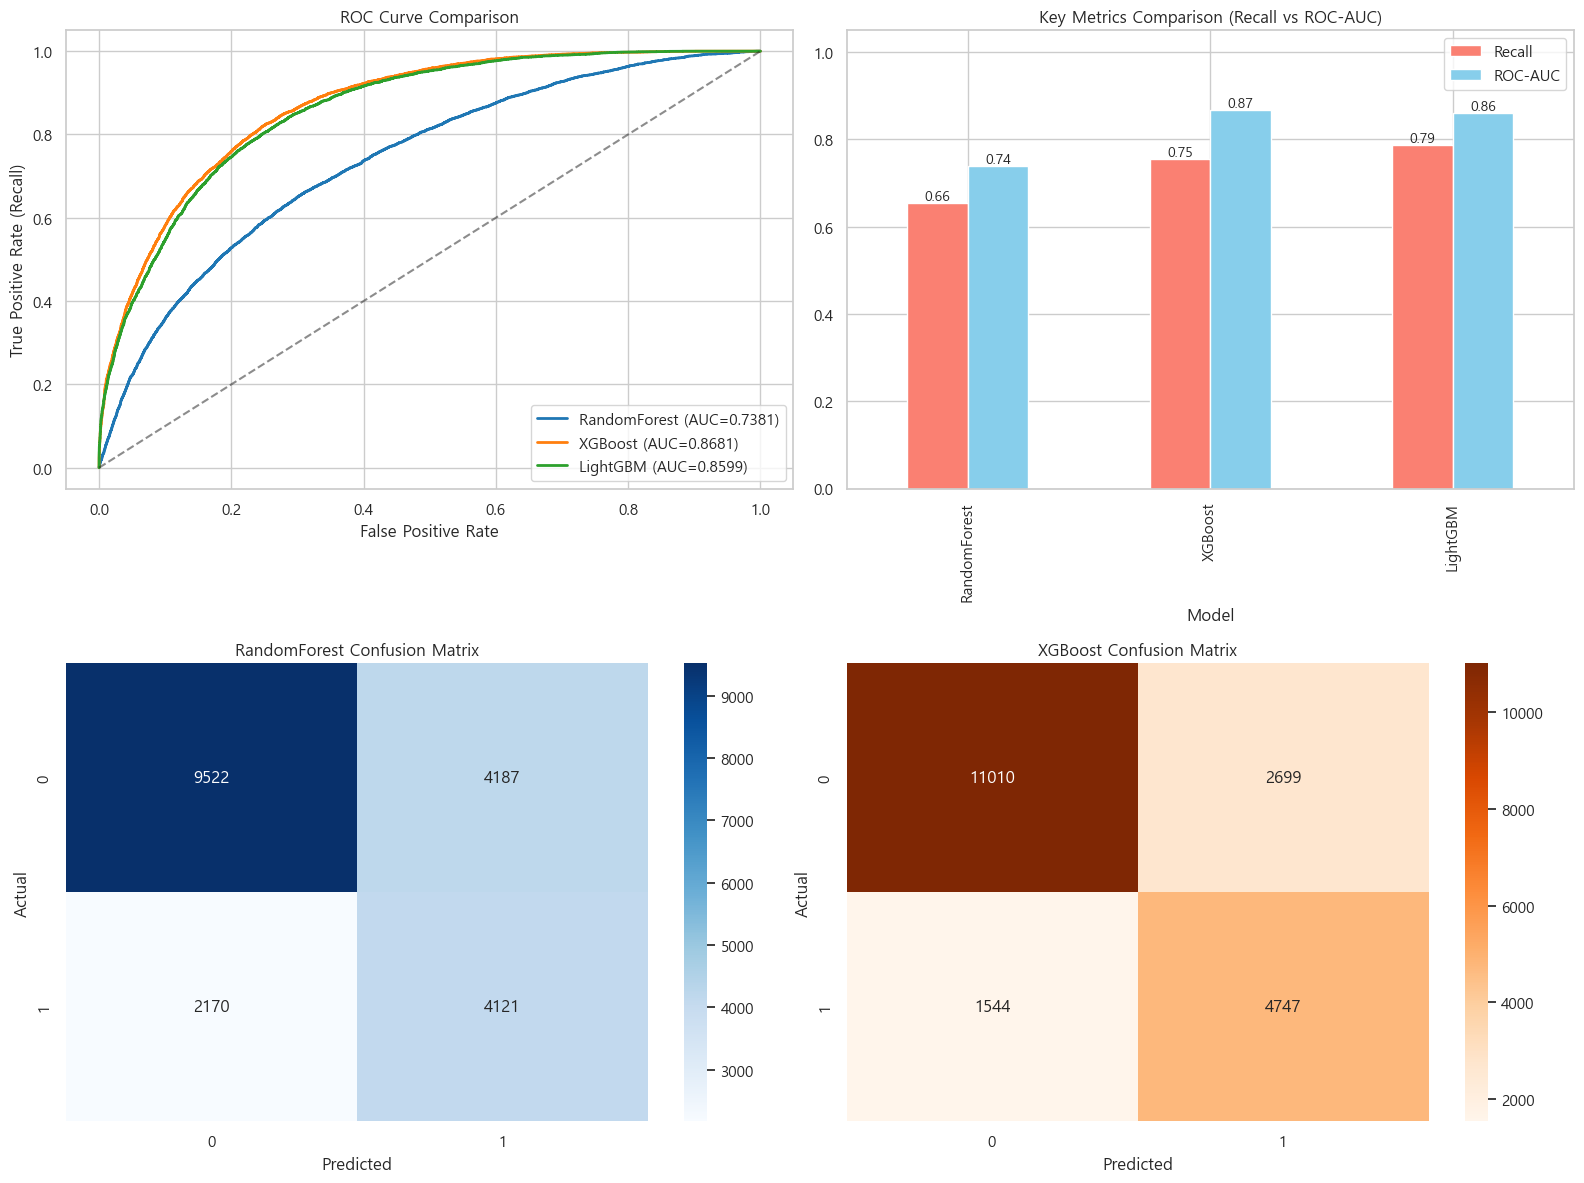


📊 [최종 성능 요약표]


,Accuracy,Recall,Precision,F1-Score,ROC-AUC
Model,,,,,
RandomForest,0.682150,0.655063,0.496028,0.564559,0.738126
XGBoost,0.787850,0.754570,0.637524,0.691126,0.868105
LightGBM,0.772500,0.786679,0.606718,0.685078,0.859860


In [70]:

# =========================================================
# [실행] 변수명만 잘 매칭해주세요!
# =========================================================

# 사용자가 가지고 있는 변수명들을 딕셔너리에 넣습니다.
my_models = {
    'RandomForest': model,       # 아까 돌린 RF 변수명
    'XGBoost': xgb_final,        # 아까 돌린 XGB 변수명
    'LightGBM': lgbm_final       # 아까 돌린 LGBM 변수명
}

# 함수 실행 (재학습 없음, 즉시 실행됨)
result_df = compare_existing_models(my_models, X_test, y_test)